In [1]:
from standardInclude import *

Welcome to JupyROOT 6.20/04
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


### Start by defining some helper functions and constants

In [2]:
#only one calo at a time for simplicity
caloToPlot = 19
allFitResults = []

In [3]:
def getWidths(h, scale=1, offset=0):
    '''
    Takes a TH2 of positions vs. time and returns a vector of time and standard deviations
    '''
    means = []
    widths = []
    times = []
    meanErrs = []
    widthErrs = []
    for bini in range(1,h.GetNbinsX()+1):
        hi = h.ProjectionY("", bini, bini)
        time = h.GetXaxis().GetBinCenter(bini)
        times.append(time)
        means.append((hi.GetMean(1)-offset) * scale)
        widths.append(hi.GetStdDev(1)*scale)
        meanErrs.append(hi.GetMean(11)*scale)
        widthErrs.append(hi.GetStdDev(11)*scale)

    dicti = {'times':times, 'widths':widths, 'widthErrs':widthErrs, 'means':means, 'meanErrs':meanErrs}
    #return(times, widths, widthErrs, means, meanErrs) 
    return dicti

In [7]:
def randomizeTimes( x, p=[None] ):
    inputtime = x[0]
    time = inputtime
    
    w0 = 2.6094;
    A = 2.80;
    tauA = 56.6;
    B = 6.18;
    tauB = 6.32;
    
    wCBO =  (w0 - (A/(tauA)) * r.TMath.Exp(-time/(1000.0*tauA)) - (B/(tauB)) * r.TMath.Exp(-time/(tauB*1000.0)) ); #MHz
    wa =  r.TMath.TwoPi() * 0.2291; #MHZ
    wc =  r.TMath.TwoPi() / 0.14919; #MHz

    factor = 1.0;
    wY = factor * (wCBO) * r.TMath.Sqrt( (2 * wc / (factor * wCBO)) -1.0 ) ;
    wVW = wc - (2.0 * wY);

    TCBO = r.TMath.TwoPi() / wCBO;
    Ta = r.TMath.TwoPi() / wa;
    TVW = r.TMath.TwoPi() / wVW;
    TY = r.TMath.TwoPi() / wY;
    T_diff= r.TMath.TwoPi()/(wCBO-wa);
    
    #time += (rng->Uniform()-0.5)*(Ta*1000.0);// w_a 4365
    timestorandomize = [
                        Ta, 
                        TCBO, 
                        TVW, 
                        TY, 
                        T_diff,
                       ]
    
    for periodi in timestorandomize:
        #time += (np.random.random() - 0.5)*(periodi)
        time += -1*np.abs((np.random.random() - 0.5))*(periodi)
    #print(inputtime, time, TCBO, Ta)
    
    #print(time, time/1000.)
    return time

---

# Matched Tracks

### Lets begin with the calo-matched tracks for the endgame, using default parameters

In [2]:
t = r.TChain("tree")
t.Add("./data/sam_trees_endgame/trackAndTrackCaloTrees_17159.root ")
t.Print()
#t.Add("./data/sam_trees_endgame/*root")

******************************************************************************
*Chain   :tree      : ./data/sam_trees_endgame/trackAndTrackCaloTrees_17159.root *
******************************************************************************
******************************************************************************
*Tree    :tree      : trackAndTrackCalo                                      *
*Entries :   172027 : Total =        63032458 bytes  File  Size =   38189864 *
*        :          : Tree compression factor =   1.65                       *
******************************************************************************
*Br    0 :midasSerialNum : midasSerialNum/i                                  *
*Entries :   172027 : Total  Size=     690368 bytes  File Size  =     129325 *
*Baskets :       19 : Basket Size=     544256 bytes  Compression=   5.33     *
*............................................................................*
*Br    1 :runNum    : runNum/i                  

In [9]:
t.Scan("clusterCaloNum","clusterCaloNum > "+str(caloToPlot-1),"",10)

3

***********************************
*    Row   * Instance * clusterCa *
***********************************
*        1 *        0 *        19 *
*        2 *        0 *        19 *
*        9 *        0 *        19 *
***********************************
==> 3 selected entries


In [15]:
%%time

matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time = r.TH3I(
            "matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time", 
            'Tracker Calo y vs. Cluster Calo y vs. Time; Cluster Time [#mus]; Beam y from tracker [mm]; Calo y from clusters [mm]',
            4698, 0, 700,
            200, -100, 100,
            200, -100,100
           )

t.Draw("clusterY:decayVertexPosY:clusterTime/1000.>>matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time",
       "clusterCaloNum > "+str(caloToPlot-1), # == not working here, not sure why.
       "goff")

CPU times: user 29.2 s, sys: 6.05 s, total: 35.3 s
Wall time: 54.8 s


10092094

Error in <TFile::Init>: file ./data/sam_trees_endgame/trackAndTrackCaloTrees_17296.root is truncated at 21004288 bytes: should be 23697316, trying to recover
Warning in <TFile::Init>: no keys recovered, file has been made a Zombie


In [16]:
print("Number of Matched Tracks:", matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time.GetEntries())

Number of Matched Tracks: 10092094.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


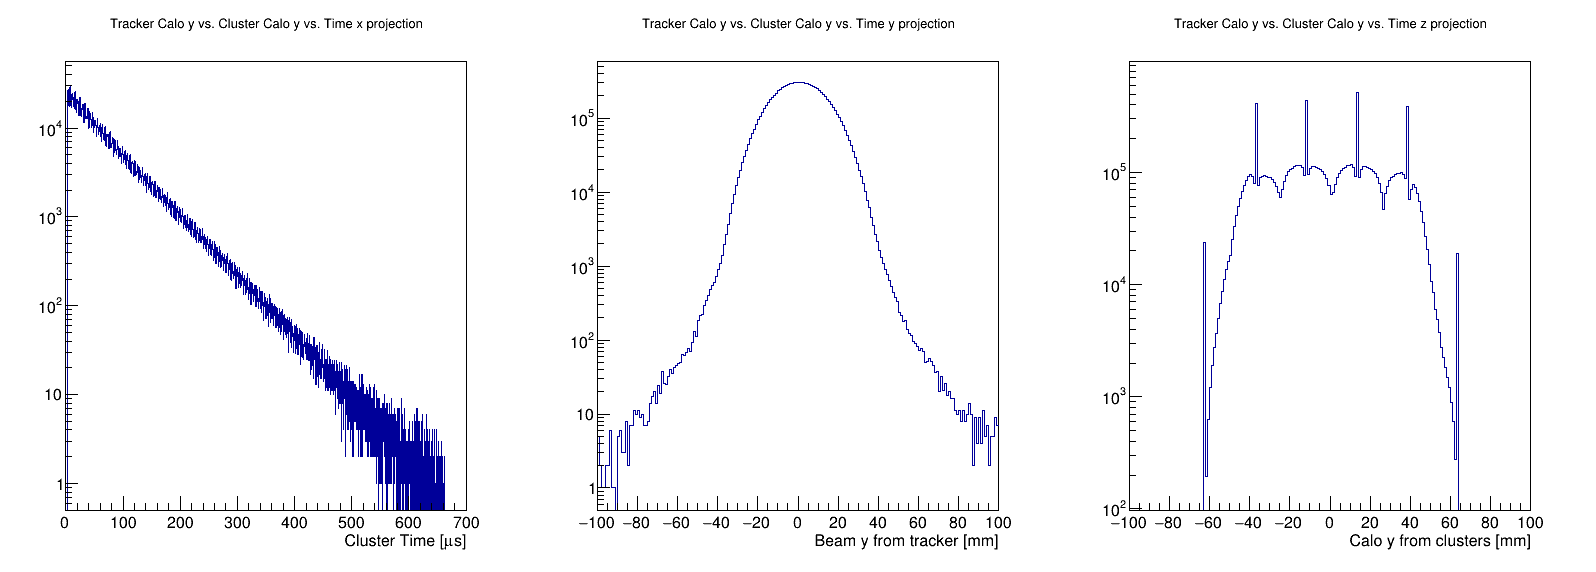

In [17]:
c = r.TCanvas("c","c",1600,600)
c.Divide(3,1)
for i, axi in enumerate(["x","y","z"]):
    c.cd(i+1)
    matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time.Project3D(axi).Draw()
    r.gPad.SetLogy()
c.Draw()

### Beam motion vs. time

In [18]:
tlow = 10
thigh = 600

func = r.TF1("func","[0] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
func.SetParNames("C", "A", "#tau", "m")
paramVec = [1,10,1,-0.0001,10]

#Beam motion vs. time
widthDict = getWidths(matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time.Project3D("yx"))

for i,xi in enumerate(paramVec):
    func.SetParameter(i,xi)
fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults.append(fitresult)

/home/jlab/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jlab/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


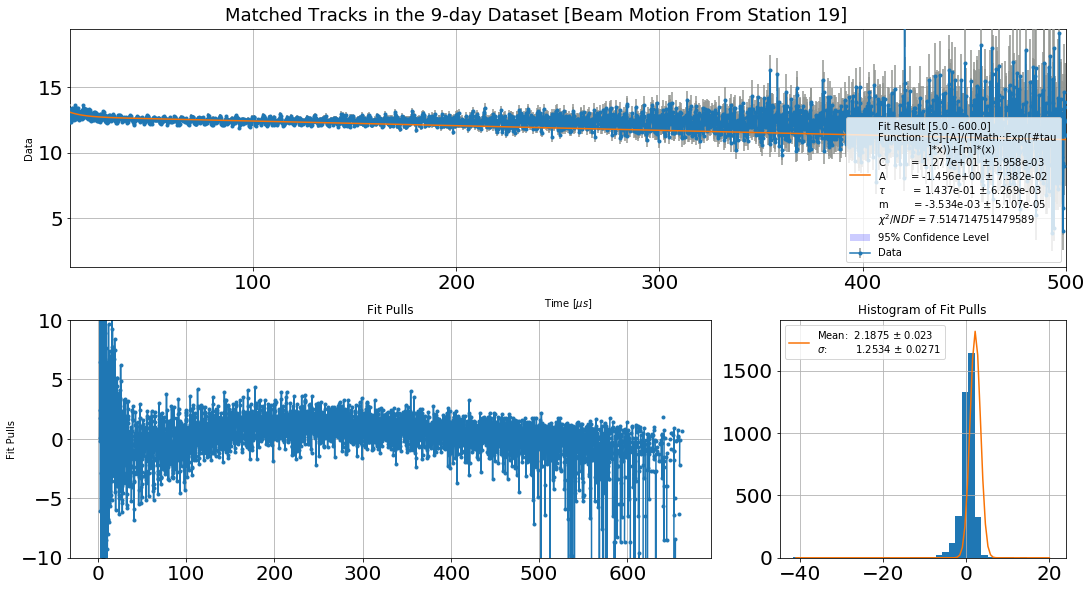

In [19]:
fig,ax = fitresult.draw("Matched Tracks in the EndGame Dataset [Beam Motion From Station "+str(caloToPlot)+"]", 
                        yrange=[None, [-10,10]], fmt=".-")
#ax[0].set_ylim(-2,2)
ax[0].set_xlim(10,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

### Calo face motion vs. time

In [20]:
tlow = 5
thigh = 600

func = r.TF1("func","[0] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
func.SetParNames("C", "A", "#tau", "m")
paramVec = [1,10,-0.1,-0.0001,10]

#Beam motion vs. time
widthDict = getWidths(matchedTracks_yCaloTracks_vs_yCaloTracker_vs_Time.Project3D("zx"))

for i,xi in enumerate(paramVec):
    func.SetParameter(i,xi)
fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults.append(fitresult)

/home/jlab/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jlab/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


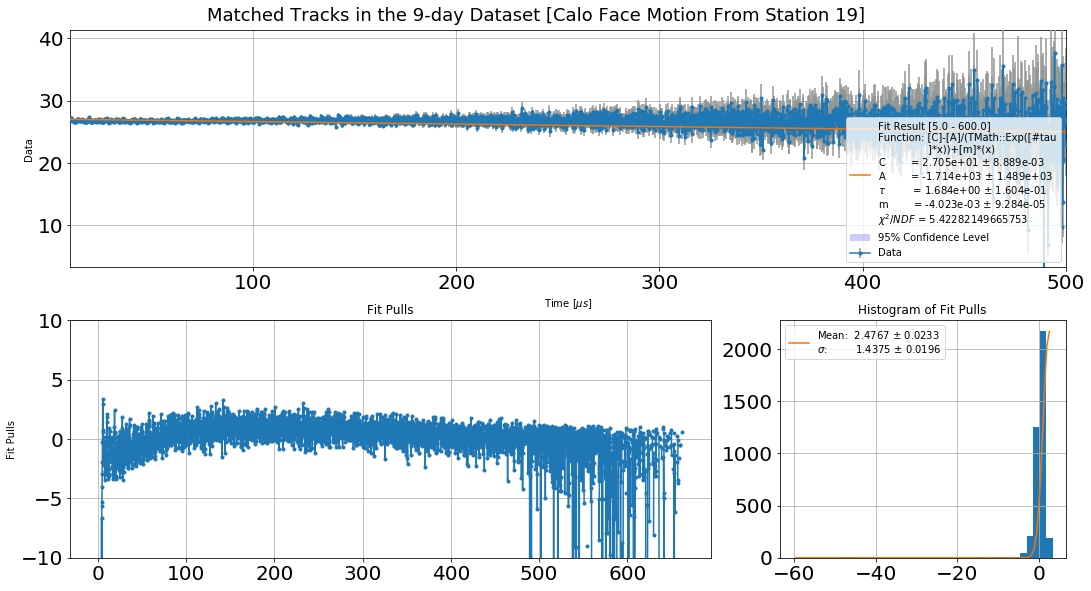

In [21]:
fig,ax = fitresult.draw("Matched Tracks in the EndGame Dataset [Calo Face Motion From Station "+str(caloToPlot)+"]", 
                        yrange=[None, [-10,10]], fmt=".-")
#ax[0].set_ylim(-2,2)
ax[0].set_xlim(10,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

---

# Extrapolate out the position without the radial field

In [10]:
%%time

#extrapolate out position ignoring radial field
vec = []

for i, e in enumerate(t):
    if(i > 100000):
        break
        
    initialMomentum = -1*e.decayVertexMomY  #From James/Joe: Backwards extrapolation flips momentum
    initialPosition = e.decayVertexPosY
    
    finalPosition = e.caloVertexPosY
    
    deltaT = e.caloVertexTime -  e.decayTime
    muonMass = 105.66# MeV
    electronMass = 0.511 #MeV
    speedOfLight = 299.8 #mm/ns
    gamma = 29.3 #just assume magic momentum
    
    #deltaY = deltaT * (initialMomentum / muonMass)*21.1 #mm
    deltaY = (deltaT * initialMomentum)/(gamma * electronMass)
    deltaY_tracker = finalPosition - initialPosition
    
    
    
    ding = [initialMomentum, initialPosition, deltaT, finalPosition, deltaY_tracker, deltaY, e.clusterCaloNum[0],
           e.caloVertexTime]
    vec.append(ding)
    #print(ding)
    
names = ['initialMomentum', 'initialPosition', 'deltaT', 'finalPosition', 'deltaY_tracker', 'deltaY', 'calo',
        'caloTime'] 
df = pandas.DataFrame(vec, columns=names)
df.head()

CPU times: user 7.45 s, sys: 797 ms, total: 8.25 s
Wall time: 8.65 s


,initialMomentum,initialPosition,deltaT,finalPosition,deltaY_tracker,deltaY,calo,caloTime
0,23.070845,1.250078,9.546875,40.566185,39.316107,14.710797,13,145491.203125
1,-29.536274,5.789762,8.953125,-33.739719,-39.529481,-17.662079,19,63240.750000
2,-32.424213,8.274569,10.070312,-46.543423,-54.817991,-21.808404,19,82101.187500
3,15.195882,-3.367542,4.796875,18.256310,21.623851,4.868507,13,97985.226562
4,-36.279453,10.943600,4.597656,-41.999252,-52.942852,-11.140603,13,49709.410156


In [4]:
muonMass = 105.66# MeV
electronMass = 0.511 #MeV
speedOfLight = 299.8 #mm/ns
gamma = 29.3 #just assume magic momentum
print(gamma * electronMass)

14.9723


In [11]:
df = df.loc[df['calo'] == caloToPlot]
df.head()

,initialMomentum,initialPosition,deltaT,finalPosition,deltaY_tracker,deltaY,calo,caloTime
1,-29.536274,5.789762,8.953125,-33.739719,-39.529481,-17.662079,19,63240.750000
2,-32.424213,8.274569,10.070312,-46.543423,-54.817991,-21.808404,19,82101.187500
9,24.520176,-8.387070,6.921875,23.878046,32.265116,11.335973,19,139552.875000
10,41.262856,-22.052868,6.365234,29.894182,51.947050,17.542244,19,16616.433594
11,19.773069,-0.334183,10.687500,33.283363,33.617546,14.114376,19,69364.484375


In [24]:
func =r.TF1("func","pol1",-100,100,2)
func.SetParameters(0,-1)
fit = fitVector(df['deltaY_tracker'], df['deltaY'], func )

#fit.draw(do_pulls=False, fmt=".")
#plt.show()

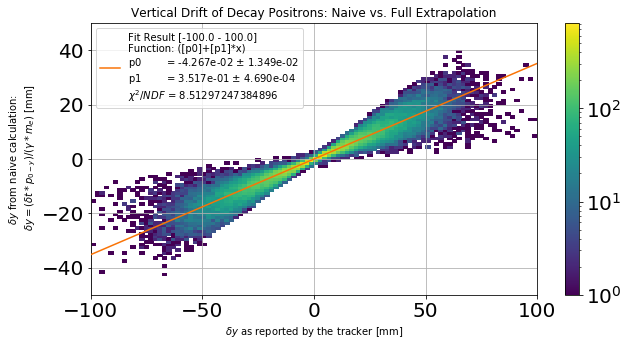

In [25]:
fig,ax = plt.subplots(figsize=(10,5))
plt.hist2d(df['deltaY_tracker'], df['deltaY'],bins=(100,100), range=[[-100,100],[-50,50]],
          norm = matplotlib.colors.LogNorm()
          )
fit.drawFitResult(ax)
#fit.drawConfidenceIntervals(ax)
plt.grid()
plt.colorbar()
plt.xlabel(r"$\delta y$ as reported by the tracker [mm]")
plt.ylabel(r"$\delta y$ from naive calculation:"+"\n"+r" $\delta y = (\delta t * p_{0-y}) / (\gamma * m_{e} )$ [mm]")
plt.title("Vertical Drift of Decay Positrons: Naive vs. Full Extrapolation")
plt.legend()
plt.show()

In [12]:
func =r.TF1("func","pol1",20,400,2)
func.SetParameters(0,-1)
fit = fitVector(df['caloTime']/1000., 
                df['deltaY']- df['deltaY_tracker'], 
                func )

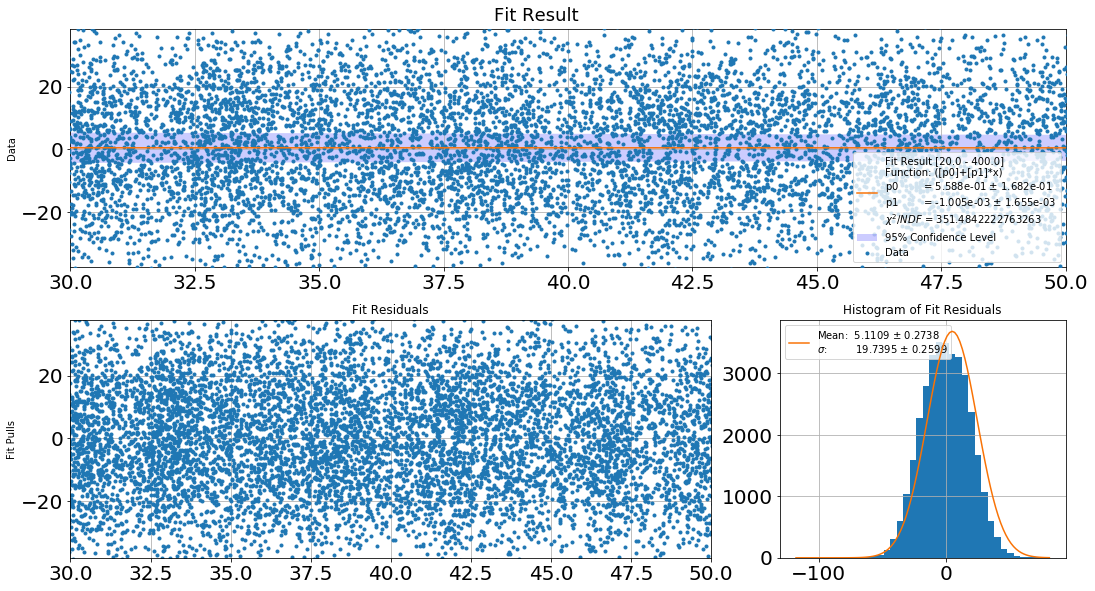

In [18]:
fig, ax = fit.draw(do_pulls=False, fmt=".")
for i in range(0,2):
    ax[i].set_xlim(30,50)
plt.show()

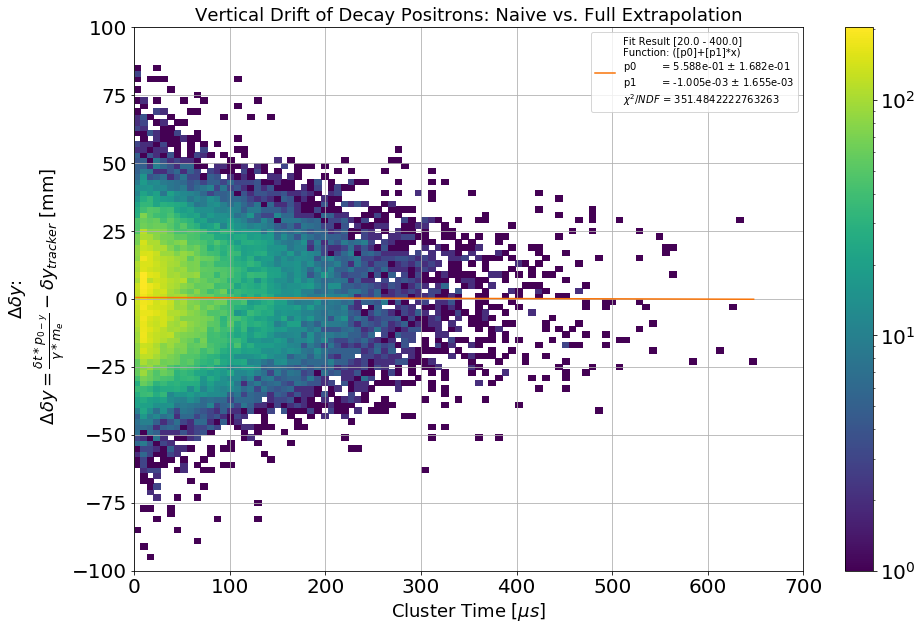

In [13]:
fig,ax = plt.subplots(figsize=(15,10))

plt.hist2d(df['caloTime']/1000.,
            df['deltaY']- df['deltaY_tracker'],  
            #c=df['initialMomentum']
           norm = matplotlib.colors.LogNorm(),
           bins=(100,100), range=[[0,700],[-100,100]]
           )
plt.xlabel(r"Cluster Time [$\mu s$]", fontsize=18)
plt.ylabel(r"$\Delta \delta y$:"+"\n"+r" $\Delta \delta y = \frac{ \delta t * p_{0-y} }{ \gamma * m_{e} } - \delta y_{tracker}$ [mm]", fontsize=18)
plt.title("Vertical Drift of Decay Positrons: Naive vs. Full Extrapolation", fontsize=18)
fit.drawFitResult(ax)
plt.legend()
plt.colorbar()
plt.grid()
plt.show()

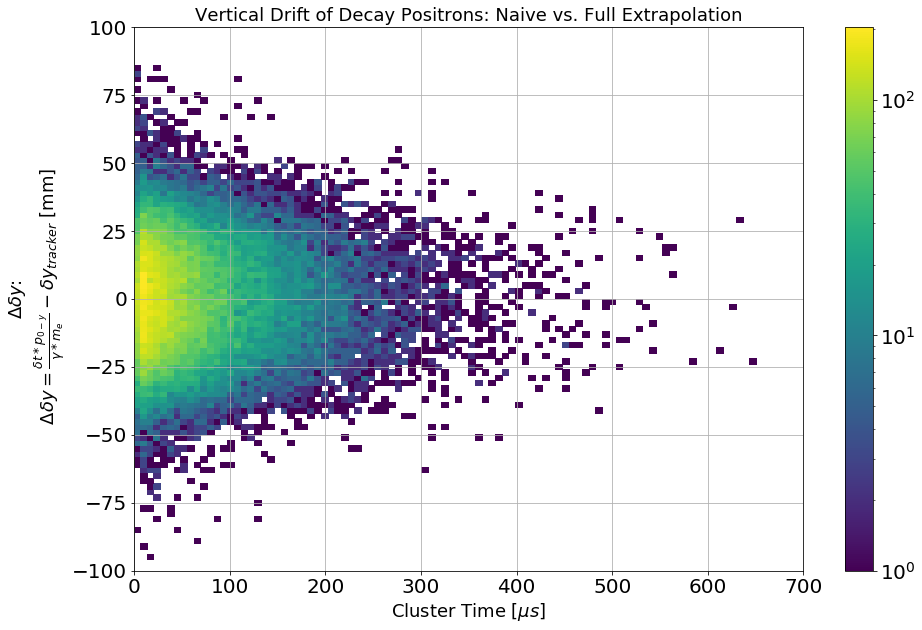

In [167]:
fig,ax = plt.subplots(figsize=(15,10))

plt.hist2d(df['caloTime']/1000.,
            df['deltaY']- df['deltaY_tracker'],  
            #c=df['initialMomentum']
           norm = matplotlib.colors.LogNorm(),
           bins=(100,100), range=[[0,700],[-100,100]]
           )
plt.xlabel(r"Cluster Time [$\mu s$]", fontsize=18)
plt.ylabel(r"$\Delta \delta y$:"+"\n"+r" $\Delta \delta y = \frac{ \delta t * p_{0-y} }{ \gamma * m_{e} } - \delta y_{tracker}$ [mm]", fontsize=18)
plt.title("Vertical Drift of Decay Positrons: Naive vs. Full Extrapolation", fontsize=18)
fit.drawFitResult(ax)
plt.legend()
plt.colorbar()
plt.grid()
plt.show()

---

# Misc. quick plots

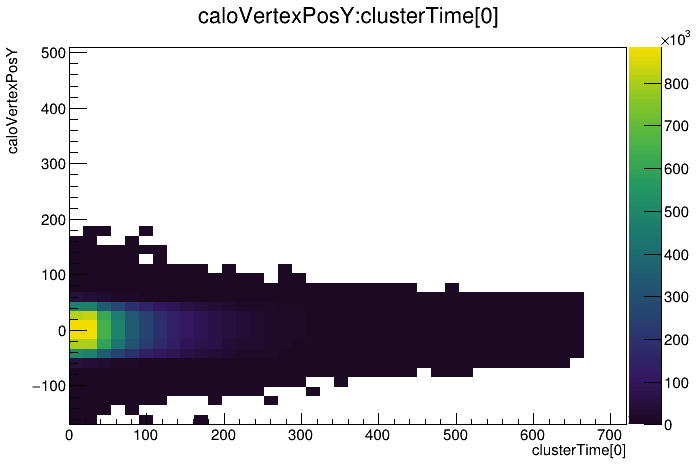

In [99]:
c = r.TCanvas()
t.Draw("caloVertexPosY:clusterTime[0]","","colz")
c.Draw()

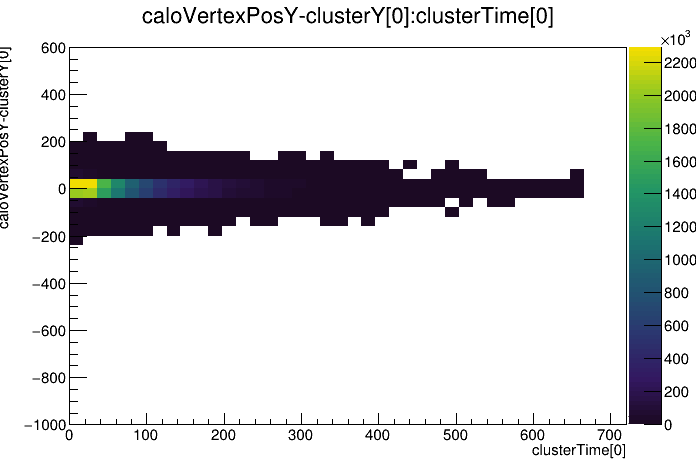

In [100]:
c = r.TCanvas()
t.Draw("caloVertexPosY-clusterY[0]:clusterTime[0]","","colz")
c.Draw()

In [131]:
h_yDiff = r.TH2I("h_yDiff",
                 "Difference in Cluster y-Position and Tracker Extrapolated y-Position vs. Time; Cluster Time [#mus]; #delta y [mm]",
                 4700*4,0,700,
                 1000,-200,200
                )
t.Draw("caloVertexPosY-clusterY[0]:clusterTime[0]/1000.>>h_yDiff","","goff")

21575417

Warning in <TFile::Append>: Replacing existing TH1: h_yDiff (Potential memory leak).


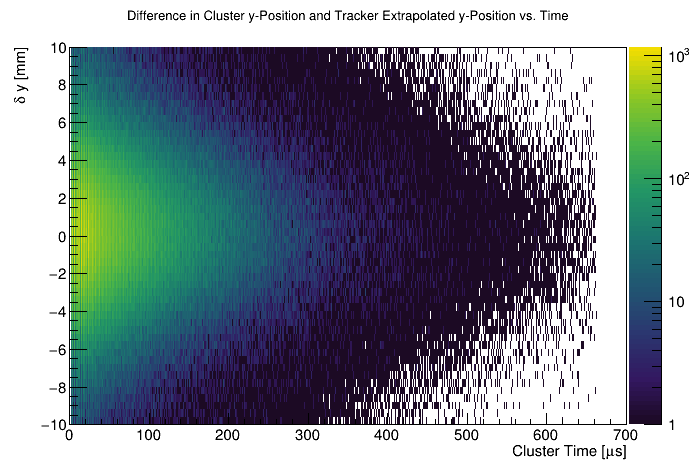

In [132]:
c = r.TCanvas()
h_yDiff.GetYaxis().SetRangeUser(-10,10)
h_yDiff.Draw("colz")
c.SetLogz()
c.Draw()


****************************************
Minimizer is Linear
Chi2                      =       385792
NDf                       =        15358
p0                        =   -0.0754296   +/-   0.000791307 
p1                        =   0.00542523   +/-   1.60461e-06 


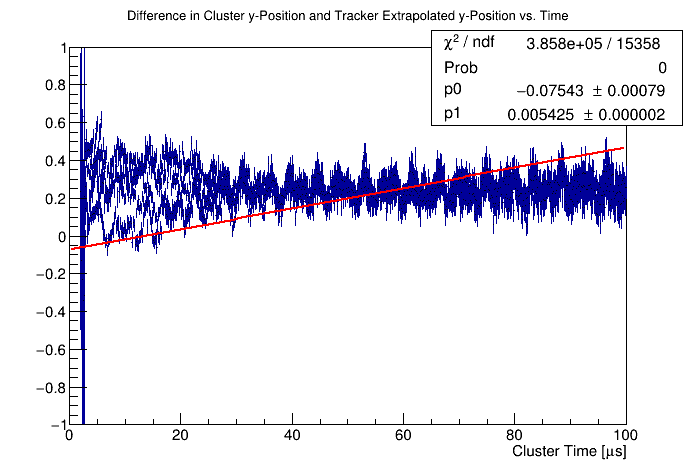

In [133]:
c = r.TCanvas()
h2 = h_yDiff.ProfileX().Clone()
h2.Fit("pol1")
h2.GetYaxis().SetRangeUser(-1,1)
h2.GetXaxis().SetRangeUser(0,100)
h2.Draw()
c.Draw()

In [ ]:
ding = TH1ToNumpyArray(h2)

In [140]:
func = r.TF1("func","pol1",30,200)
fitresult = fitVector(ding[0], ding[1], func, None, ding[2])

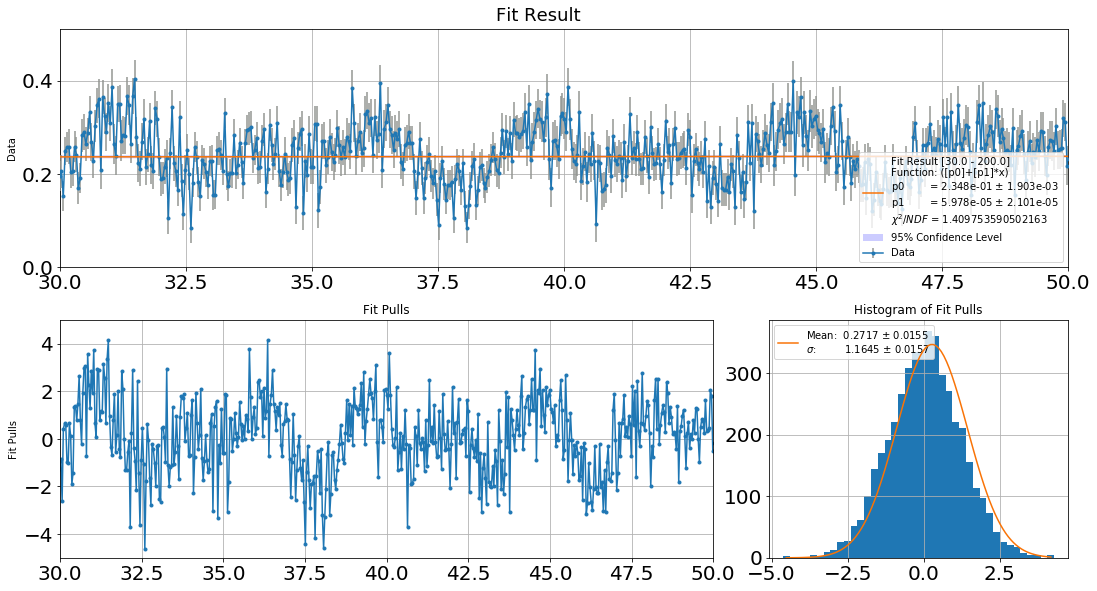

In [157]:
fig,ax = fitresult.draw()
for i in range(0,2):
    ax[i].set_xlim(30,50)
ax[0].set_ylim(0,0.51)
ax[1].set_ylim(-5,5)
plt.show()

Restricting range of FFT to: [25, 200]


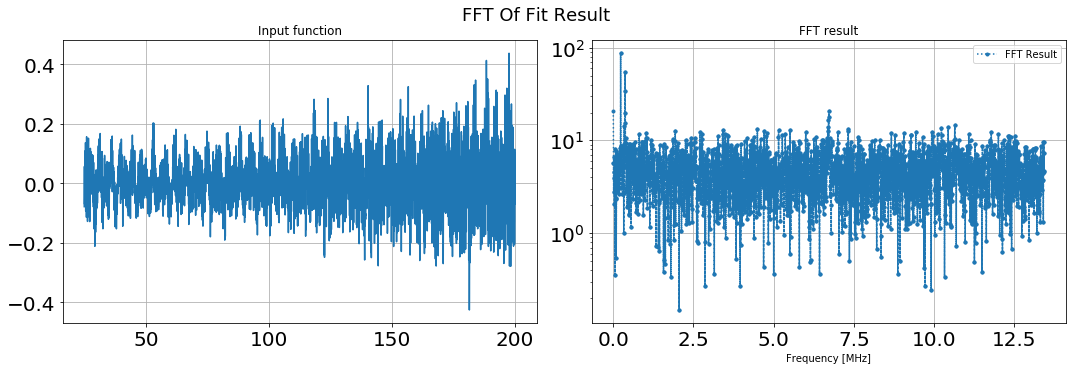

In [158]:
bins, amp = fitresult.fft([25,200],option=1)

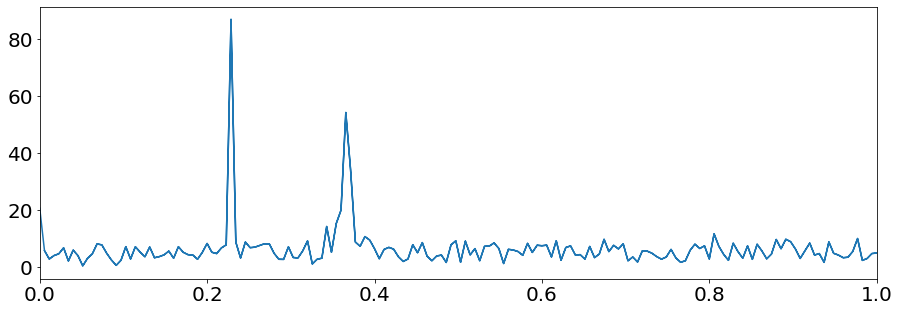

In [159]:
fig,ax = plt.subplots(figsize=(15,5))
plt.plot(np.abs(bins), np.abs(amp))
plt.xlim(0,1)
plt.show()

---

### Now lets load up the endgame clusters by themselves

In [27]:
f = r.TFile("./data/results_endgame_position_may19.root")
f.ls()

TFile**		./data/results_endgame_position_may19.root	
 TFile*		./data/results_endgame_position_may19.root	
  KEY: TDirectoryFile	verticalPosition;1	verticalPosition (CaloHitPositions) folder


In [51]:
#h = f.Get("verticalPosition/clusters"+str(caloToPlot)).Clone()
h = f.Get("verticalPosition/randclusters"+str(caloToPlot)).Clone()
h.SetDirectory(0)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


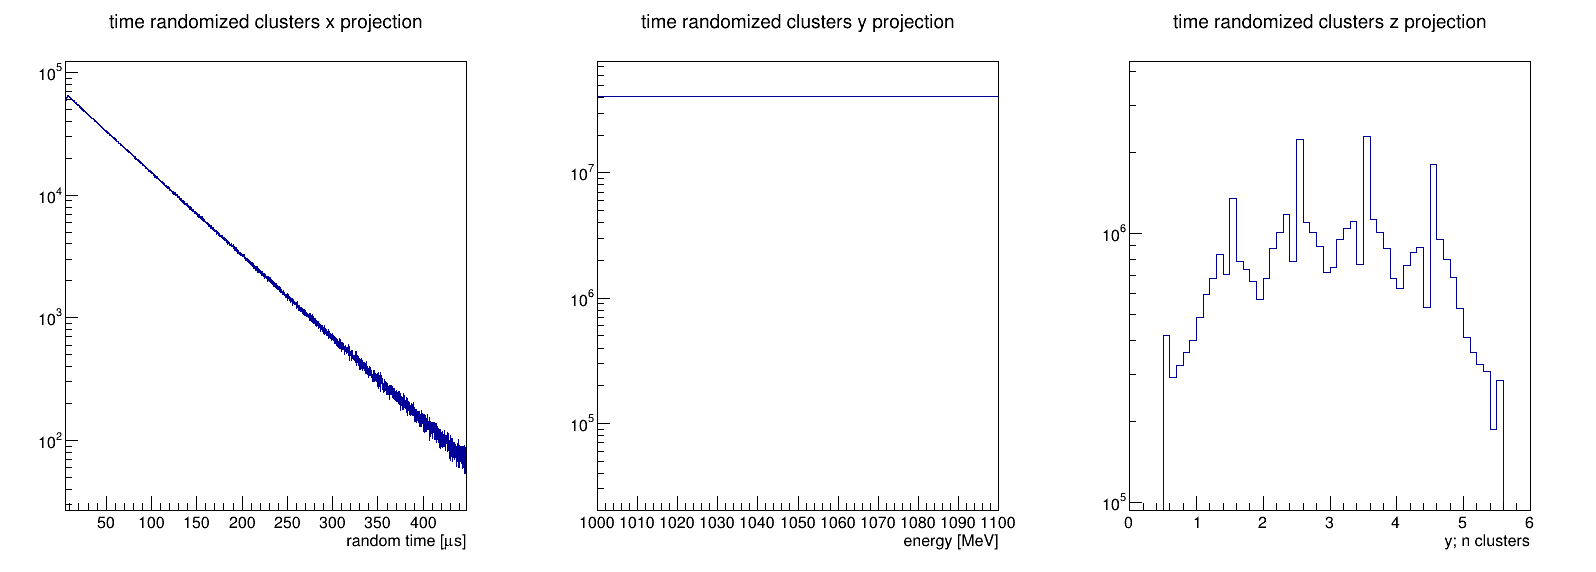

In [65]:
c = r.TCanvas("c","c",1600,600)
c.Divide(3,1)
for i, axi in enumerate(["x","y","z"]):
    c.cd(i+1)
    h.Project3D(axi).Draw()
    r.gPad.SetLogy()
c.Draw()

In [82]:
#set energy range

e1 = 1000
e2 = 2400


h.GetYaxis().SetRange(h.GetYaxis().FindBin(e1),h.GetYaxis().FindBin(e1))
allClusterY_vs_Time = h.Project3D("zx").Clone("allClusterY_vs_Time")

allClusterY_vs_Time.Rebin2D(1,1)
widthDict = getWidths(allClusterY_vs_Time, scale=25, offset=3)

In [96]:
tlow = 10
thigh = 600

func = r.TF1("func","[0] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
func.SetParNames("C", "A", "#tau", "m")
paramVec = [1,10,-0.1,-0.0001,10]

for i,xi in enumerate(paramVec):
    func.SetParameter(i,xi)
#fitresult = fitVector(times, means, func, None, meanErrs)
fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
#fitresult = fitVector(widthDict['times'], widthDict['means'], func, None, widthDict['meanErrs'])

#fitresult = fitVector(times, widths, func, None, widthErrs)
allFitResults.append(fitresult)

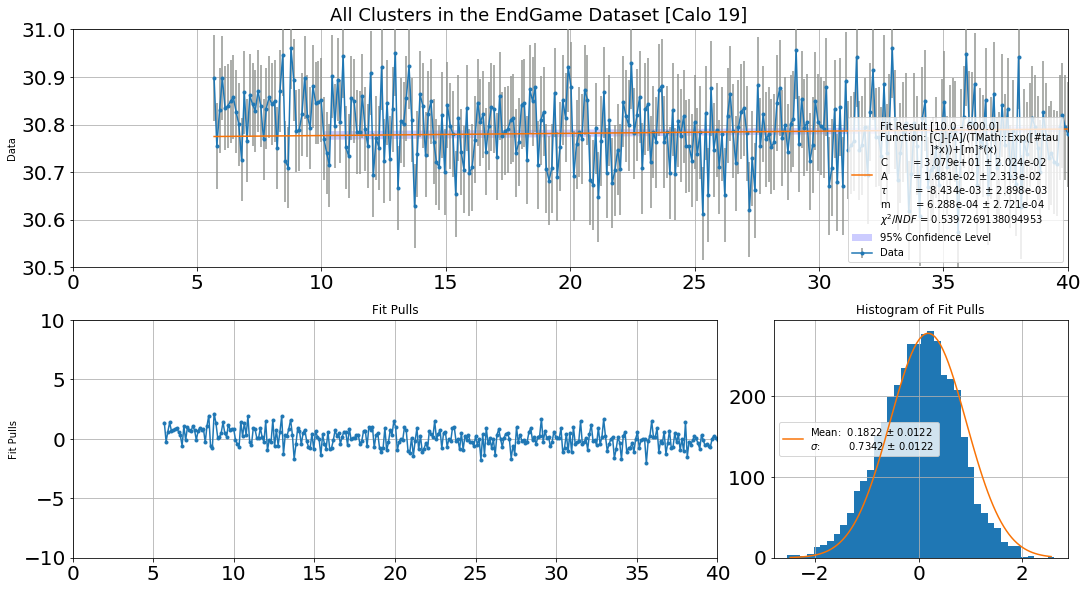

In [97]:
fig,ax = fitresult.draw("All Clusters in the EndGame Dataset [Calo "+str(caloToPlot)+"]",
               yrange=[None, [-10,10]])
for i in range(0,2):
    ax[i].set_xlim(0,40)
ax[0].set_ylim(30.5,31)
plt.show()

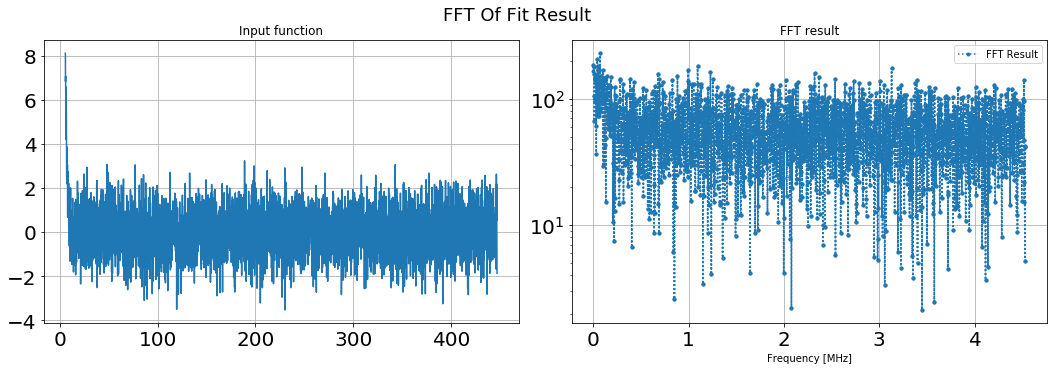

(array([ 0.        ,  0.00226486,  0.00452973, ..., -0.00679459,
        -0.00452973, -0.00226486]),
 array([166.05513117 +0.j        , 166.96697417+79.78113779j,
        179.44080395-14.61392392j, ..., 155.6435796 +21.83836274j,
        179.44080395+14.61392392j, 166.96697417-79.78113779j]))

In [90]:
fitresult.fft(option=2)